Foreword
========

Lately, we've been seeing a [lot](http://arstechnica.com/information-technology/2015/12/facebooks-open-sourcing-of-ai-hardware-is-the-start-of-the-deep-learning-revolution/) [of](https://www.tensorflow.org/) [attention](http://www.wired.com/2016/01/googles-go-victory-is-just-a-glimpse-of-how-powerful-ai-will-be/) being drawn to a machine learning field called _deep learning_. Deep learning has been outperforming several other techniques in problems ranging from object recognition in images to speech recognition to natural language processing. Not only that, but "deep learning" is also now on it's way to outperform both "big data" and "cloud" in the ranking of most used management-level buzzwords. Jokes aside, it is in fact an incredibly powerful and flexible tool. 

Deep learning is a discipline built on top of another machine learning area related to _artificial neural networks_ (ANNs). I have superficially studied ANNs in at least two graduation courses, but I have never properly worked with them. The idea of this post is recalling some of that stuff and actually getting our hands dirty with some real code. We're going to actually implement a simple neuron computationally as we study it. Once we get the basis right, we'll move along to more complex neural architectures.

This is an "ipython notebook" document, which is a mix of text, math typesetting and python code you can actually run. It's a great tool for discussing ideas and data science in general. This style of post was heavily influenced by [Peter Norvig's notebooks](http://norvig.com/ipython/README.html), which I couldn't recommend more. I tried to stick to some principles while writing this:

- Keep it dead simple
- Do not overengineer
- Do not to use scary, fancy names without notice
- Bottom up, incremental knowledge building

Introduction
============

The study of artificial neural networks has been heavily motivated by how biological learning systems work. Our brain, for instance, has a hugely complex network of incredibly simple units, called _neurons_. This web is estimated to have around $10^{11}$ neurons, each connected to around $10^{4}$ others [0].

To put it in a hugely simplified way, in this massive interconnected network neurons typically receive inputs from other neurons, which causes the neuron to be "excited" or "inhibited". If the neuron is excited, it's output will act as input to some other neurons, and so the signal is propagated though the network.

One incredibly interesting characteristic of this network is that even though each neuron is a relatively simple unit, somehow by having a _huge_ amount of them allows us to make mind-blowinly complex decisions _fast_. The question then is: can we construct a similar architechture and hopefully somehow emulate this behavior computationally?

Okay. Let's try to reason about how we'd approach modeling a single neuron mathematically. We mentioned that each neuron has _inputs_ and an _output_, which is either "excited" or "inhibited", depending on the values of the inputs. We can model such relationship between inputs and output as a function whose output is either $+1$ (excited state) or $0$ (inhibited state).

There are many ways to model that function. One common artificial neuron, called [Perceptron](https://en.wikipedia.org/wiki/Perceptron) adopts the strategy of outputting $+1$ whenever the sum of the inputs, multiplied by some constants, is greater than zero and outputing $0$ otherwise. So, if we assume our simple neuron has two inputs, this relationship between _inputs_ and _output_ becomes:


$$
    output(inputs) = 
\begin{cases}
    +1,& \text{if } weight_1 \times input_1 + weight_2 \times input_2 \geq 0\\
    0,              & \text{otherwise}
\end{cases}
$$

This relationship is commonly nicely represented with an image:


![caption](files/perceptron.png)


Where:

- Inputs: $x_1$, $x_2$;
- Weights: $w_1$, $w_2$;
- Sum: responsible for calculating $w_1x_1 + w_2x_2$. The summation's output is called _linear output_
- Activation function: receives the _linear output_ and outputs either a $+1$ or a $0$. This function in particular is known as the step function or Heaviside function.

In [1]:
# First, let's just import some python libraries we'll use in this document
%pylab --no-import-all inline
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np

# Making default plot sizes a little bigger
figsize(7, 6)

Populating the interactive namespace from numpy and matplotlib


Starting small
==============

Let's start our discussion with a single simple neuron. To get things up to speed, let's waste no time and investigate the behavior of a Perceptron with a concrete implementation. If you recall the introduction, in order to implement a single neuron in, we need to be able to perform the following operations:

- Sum the inputs multiplied with the percentron's weights to produce the _linear ouput_
- Run the linear output through the Heaviside function to get the binary _output_

In the spirit of not overengineering things, let's translate those two operations into python code:

In [2]:
def perceptron_linear_output(weights, inputs):
    return sum(weights * inputs)

def heaviside(linear_output):
    return 1. if linear_output >= 0. else 0.

def perceptron_output(weights, inputs):
    return heaviside(perceptron_linear_output(weights, inputs))

That was very straight forward. We now have the operations a perceptron must perform. All that's left for us is to come up with a way of representing the perceptron itself. For now, the only thing a perceptron really _has_ is its weights, so a braindead way of representing a perceptron is simply by a list of its weights:

In [3]:
perceptron = np.array([1., 1.])

Note that instead of using python's default list, I'm using numpy's `array` type. Either choice is just fine, but I'm leveraging the fact that numpy's `array` type automatically handles the element-wise multiplication between two vectors. That is, doing `np.array([1, 2]) * np.array([3, 4])` will compute `[1*3,  2*4]`, while we would have had to implement that behavior for python's default list, which would also have been no problem.

## Decision boundary

That was easier than I had anticipated! With our concrete perceptron implementation in hands, we're ready to start our investigation.

We saw that, for any input, our little perceptron has a binary output. For every possible pair of inputs $(x_1, x_2)$, it will output $+1$ for some of them and $0$ for the rest. The points for which it will output $+1$ are the ones that cause the linear output to be positive. These are the inputs that satisfy the inequation:

$$w_1x_1 + w_2x_2 >= 0$$

Analogously, our perceptron will output $0$ for points satisfying

$$w_1x_1 + w_2x_2 < 0$$

That suggests there is a "boundary" that separates points for which the perceptron outputs $+1$ and $0$. Since we're dealing with two inputs, we can represent all possible inputs as points on the cartesian plane, whose axes are $x_1$ ($x$) and $x_2$ ($y$).

Doing so allows us to recognize that the boundary given by $w_1x_1 + w_2x_2 = 0$ is, in fact, a disguised (or implicit) line equation! Let's try to visualize the decision boundary for the perceptron we created:

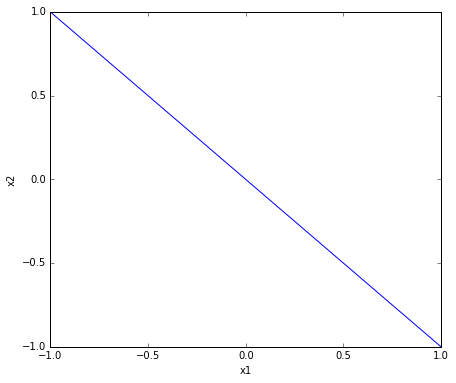

In [4]:
def plot_decision_boundary(perceptron, axis_range=(-1, 1)):
    # Let's transform the implicit equation given by w1*x1 + w2*x2 = 0 into
    # an explicit function of x1. That is,
    # x2 = -x1*w1/w2
    def x2(x1):
        return -x1*perceptron[0]/perceptron[1]
    plt.plot(axis_range, map(x2, axis_range))
    plt.xlabel("x1")
    plt.ylabel("x2")
    
plot_decision_boundary(perceptron)

Okay, that looks good. That blue line represents the decision boundary for our little perceptron. That is, it represents the exact equation:

$$1x_1 + 1x_2 = 0$$ 

To recap:

- For points to the _right_ of the blue line, $ x_1 + x_2 > 0 $, so our output will be $1$;

- For points to the _left_ of the blue line, $ x_1 + x_2 < 0 $, so our output will be $0$;

Let's try a few points to see if we're correct so far:

Are all righties mapped to 1? => True
Are all lefties mapped to 0? => True


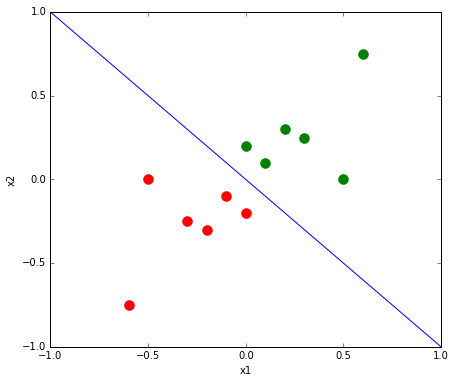

In [5]:
righties = np.array([
    [.5, 0], [.1, .1], [.2, .3], [.3, .25], [.6, .75], [0, .2]
])

lefties = -1 * righties

def plot_points(points, style="b.", markersize=20):
    x1, x2 = zip(*points)
    plt.plot(x1, x2, style, markersize=markersize)

plot_points(righties, "g.")
plot_points(lefties, "r.")
plot_decision_boundary(perceptron)

righties_outputs = map(lambda point: perceptron_output(perceptron, point), righties)
print "Are all righties mapped to 1? =>", all(map(lambda output: output == 1, righties_outputs))

lefties_outputs = map(lambda point: perceptron_output(perceptron, point), lefties)
print "Are all lefties mapped to 0? =>", all(map(lambda output: output == 0, lefties_outputs))

Good! It seems like we're on to something here. Let's dig a little further.

## Classification

Alright. So far, so good. We are now able to represent decisions boundaries that separates two types of points - lefties and righties. Using that idea, we can already acomplish a hugely important machine learning task: classification! That means we can use our perceptron to __classify__ any given point on a plane as being either a lefty or a righty.

In this simple scenario, let's say someone handed us a pair of coordinates $(x_1, x_2)$ and asked us to classify that point as being either a lefty or a righty. Now, we already went though the trouble of modeling the decision boundary and implementing our perceptron, so let's just have the computer do the hard work for us:

The unlabeled point with coordinates [-0.29824016 -0.73991711] is a lefty


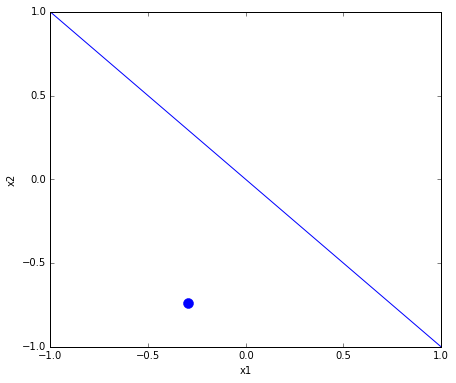

In [6]:
# Let's create a random point with coordinates bound between (-1, 1)
unlabeled_point = np.random.uniform(-1, 1, 2)

# And use our perceptron to  identify the label
label = "righty" if perceptron_output(perceptron, unlabeled_point) == 1 else "lefty"

print "The unlabeled point with coordinates {} is a {}".format(unlabeled_point, label)

# Of course me trusts the mathz! Let's also plot it, you know, just in case.
plot_points([unlabeled_point])
plot_decision_boundary(perceptron)

In real-world applications, classification tasks can be used in many many scenarios. For instance:

- Computer vision: Given an image of an animal, is it a dog or a cat?
- Language processing: Given a sound wave of someone speaking, is she saying "man" or "moon" (or anything else)?
- Spam detection system: Given the text of an email, is it spam? Or is it ham (email you actually want)?

## Bias

Honestly, how cool is that? Using just a few lines of code, we're able to create a simple model and use it to classify unlabeled data points. Our simple perceptron model has one little shortcoming, though. We can only represent decision boundaries of the form $ax_1 + bx_2 = 0$. In other words, every decision boundary we can represent so far necessarily goes though the origin (the [0, 0] point).

To solve that, we want to be able to represent more general decision boundaries. In two dimensions, we might want to represent decision boundaries of the form:

$$ ax_1 + bx_2 + c = 0 $$

The new $c$ term, usually called __bias__, is responsible for _shifting_ our simple linear decision boundary up and down. Let's plot a biased and an unbiased decision boundary for intuition:

(-1.0, 1.0, -2.0, 1.0)

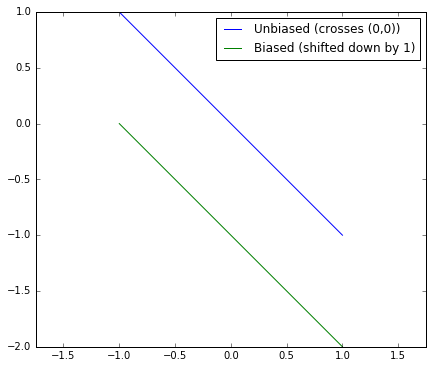

In [7]:
# To make it more compatible with our perceptron implementation, let's represent the
# equation ax1 + bx2 + c = 0 as a list of weights [c a b]

# x1 + x2 = 0
unbiased_decision_boundary = [0, 1, 1]

# x1 + x2 + 1 = 0
biased_decision_boundary = [1, 1, 1]

# We also need to tweak the way we plot the decisions boundaries to
# account for the new `c` term
def plot_decision_boundary(weights, axis_range=(-1, 1), label=""):
    # Again, we'll transform the implicit equation ax1 + bx2 + c = 0
    # into the function x2(x1) = (-ax1 - c)/b
    def x2(x1):
        return (-x1*weights[1] - weights[0])/weights[2]
    plt.plot(axis_range, map(x2, axis_range), label=label)
    
plot_decision_boundary(unbiased_decision_boundary, label="Unbiased (crosses (0,0))")
plot_decision_boundary(biased_decision_boundary, label="Biased (shifted down by 1)")
plt.legend()
plt.axis("equal")

So now we know what a generic linear decision boundary looks like. All we need to do is think of a way to plug that idea into our perceptron. Let's see:

- Right now, our perceptron has two inputs, $x_1$ and $x_2$, and two weights, $w_1$ and $w_2$, with which it can compute the decision boundary $w_1x_1 + w_2x_2 = 0$
- What we want is to be able to represent a decision boundary of the form $w_1x_1 + w_2x_2 + w_0 = 0$

The way this problem is usually tackled is by creating a new "virtual input" to the perceptron. This input, unlike the regular ones, has always the same value of $1$. By having this input multiplied by a new weight, which we'll call $w_0$, we can arbitrarily shift our decision boundaries up and down as we wish. To wrap it up, our input vector will look something like `[1 x y]`, and the perceptron weight vector will look something like `[w0 w1 w2]`, so that when we multiply both, we get `w0*1 + x1*w1 + x2*w2`, which is exactly the generic linear decision boundary we were looking for.

From now on, we're gonna have the small extra hassle of carrying the extra weight (pun intended, please). That's not much trouble, though. All we need to do is represent our perceptrons as triplets of weights and modify the `linear_ouput` function accordingly:

In [8]:
def perceptron_linear_output(weights, inputs):
    # Insert the virtual input 1. in the beggining of `inputs`
    inputs_with_bias = np.insert(inputs, 0, 1.)
    return sum(weights * inputs_with_bias)

## Learning from examples

We've seen how to represent simple, linear decision boundaries and how to classify unlabeled points. That's already fascinating for such a simple model and works just fine, __given we have a useful decision boundary__ to begin with.

The true power of using neural networks, though, comes from the fact that we can _teach_ it how to classify data by supplying it with a bunch of examples. Now, I have worked a few times with learning models, but I have to say this idea simply blows my mind. Seriously, how cool is that?

To put it in the context of our previous examples, we can _train_ our perceptron so that it learns the difference between "righties" and "lefties" __without us having to tell it initially what the decision boundary is__, simply by supplying it with some examples of what are "righties" and what are "lefties".

If that sounds too magical to you as it does to me, keep reading me and we'll try to come up with a concrete example.

The first step is to generate a bunch of _training data_, which can be represented as a list of pairs of `(point, label)`. We want it to look something like:

```
training_data = [
    ((-1, -1), "lefty")),
    ((-1, -10), "lefty")),
    ((5, 10), "righty")),
    ((10, 2), "righty")),
    ...
 ]
 ```
 
This type of task is commonly called _supervised learning_, since we have both inputs and the desired output in our learning data. That is, our training data is _labeled_ (in this case, each training data point is labeled as being either a "righty" or "lefty").

### Generating training data

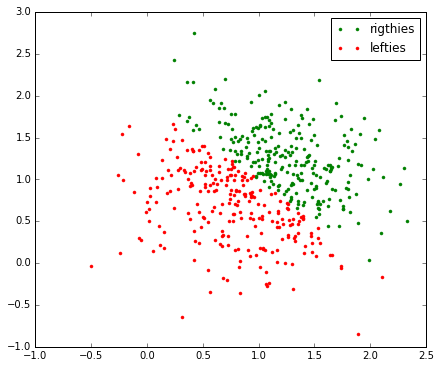

In [9]:
# First step: generate 500 random points (x1, x2 coords) centered around the (1., 1.) point.
training_data = [np.random.normal(1, .5, 2) for i in xrange(500)]

def attach_label(point):
    return (point, "righty" if point[0] + point[1] >= 2. else "lefty")
    
# Second step: attach labels to the points
labeled_training_data = [attach_label(point) for point in training_data]

# Let's also plot our training_data for intuition
righties_training_data = [td[0] for td in labeled_training_data if td[1] == "righty"]
lefties_training_data = [td[0] for td in labeled_training_data if td[1] == "lefty"]

def plot_tuples(tuples, *args, **kwargs):
    x1s, x2s = zip(*tuples)
    plt.plot(x1s, x2s, *args, **kwargs)
    
plot_tuples(righties_training_data, "g.", label="rigthies")
plot_tuples(lefties_training_data, "r.", label="lefties")
plt.legend()

We now have our training data. Looking at the big picture, what we want is a way to feed this labeled training data to our perceptron and have it automagically learn a good decision boundary for it. If everything goes according to plan, we should see our decision boundary really near the junction between the green and red dots on the plot above. That would mean that everything to the right of the boundary is a "righty" and everything to the left, a "lefty".

## A simple learning algorithm

Intuitively, here's how a learning algorithm might work:

- For every (point, label) in our training data, do:
    * Calculate the perceptron output for that point. Does it match the label (the expected output) in the training data?
        - If it does, great, move to the next training example;
        - If it does not, tweak the perceptron weights just a little bit so it performs better on that example;
        
Mitchell [0] calls this learning algorithm the "perceptron update rule". Let's try to convert the English description of it into python code:

In [10]:
def train_perceptron(perceptron, training_data, learning_rate=0.1):
    for training_inputs, training_output in training_data:   
        output = perceptron_output(perceptron, training_inputs)
        
        # Attach the "virtual" input 1.0 to the training data in position 0
        training_inputs_with_bias = np.insert(training_inputs, 0, 1.)
        
        # If training_output is different from the perceptron output, 
        # generate small increments in weights in order to lessen that difference
        deltas = learning_rate*(training_output - output)*training_inputs_with_bias
        perceptron += deltas

The `learning_rate` parameter is responsible for making the adjustments "small". If we tweak the perceptron weights too much in every iteration, we might "overdo" the corrections and never agree upon a "correct" model. If we make super small adjustments, we might end up never really "getting there". I know, I know. That's a lot of quotes. Those are somewhat abstract notions. In fact, choosing a good learning rate is not an easy task. An initial small value around `0.1` is enough for us to get started, though.

Let's try this baby out.

Initial bias -0.0134415758054


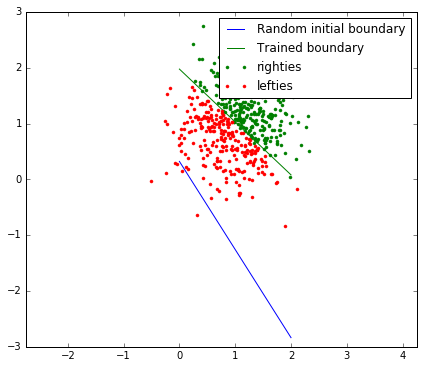

In [24]:
# Note that our perceptron now has 3 weights. Also, since I'm _that_ afraid of commitment,
# I'm initializing the weights with small values between -.1 and +.1
perceptron = np.random.uniform(-.1, .1, 3)

print "Initial bias", perceptron[0]

def get_value_from_label(label):
    return 1. if label == "righty" else 0.

valued_training_data = [(point, get_value_from_label(label)) for point, label in labeled_training_data]

plot_decision_boundary(perceptron, label="Random initial boundary", axis_range=(0,2))

# Fingers crossed...
train_perceptron(perceptron, valued_training_data)

def plot_perceptron_and_training_data(perceptron, label="Trained boundary", axis_range=(0,2)):
    plot_decision_boundary(perceptron, label=label, axis_range=axis_range)
    plot_tuples(righties_training_data, "g.", label="righties")
    plot_tuples(lefties_training_data, "r.", label="lefties")
    plt.xlim(axis_range)
    plt.axis("equal")
    plt.legend()

plot_perceptron_and_training_data(perceptron)

It... looks like it more or less worked! Let's zoom in a little bit:

[0.5, 1.5, 0.5, 1.5]

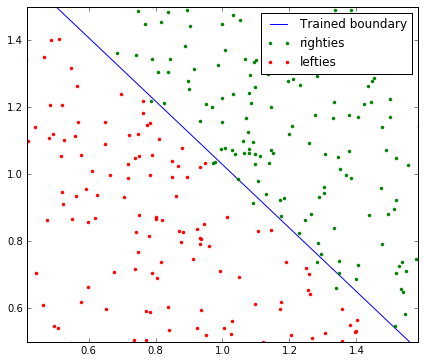

In [25]:
plot_perceptron_and_training_data(perceptron)
plt.axis([.5, 1.5, .5, 1.5])

It does look pretty good! The quality of this initial training step will depend on initial weights as well as on the training data, which are generated randomly. That being said, results _will_ vary if you run this step twice. In most cases, if we look really close, though, we can still see some red-lefties being classified as righties and/or some green-righties being classified as lefties.

One quick way to "solve" this is to keep running the training algorithm over and over with the same training data until it classifies all points correctly. Let's try to do so by making `train_perceptron` return the number of misclassified points and by creating a helper function called `train_perception_until_no_misclassifications` that will run `train_perceptron` until it classifies all training data correctly.

In [13]:
def train_perceptron(perceptron, training_data, learning_rate=0.1):
    n_misclassified = 0
    for training_inputs, training_output in training_data:   
        output = perceptron_output(perceptron, training_inputs)
        
        if abs(training_output - output) > 1e-5:
            n_misclassified += 1
            
        training_inputs_with_bias = np.insert(training_inputs, 0, 1.)
        deltas = learning_rate*(training_output - output)*training_inputs_with_bias
        perceptron += deltas
    
    return n_misclassified

def train_perceptron_until_no_misclassifications(perceptron, training_data, learning_rate=0.1):
    n_iterations = 0
    n_misclassified = len(training_data)
    
    while n_misclassified:
        n_misclassified = train_perceptron(perceptron, training_data, learning_rate)
        n_iterations += 1
    
    return n_iterations

Note that, inside `train_perceptron`, I'm using `abs(float1 - float2) > 1e-5` instead of `float1 == float2`. When testing floats for equality, we should always be aware that they're represented with limited precision. It's a good idea to always compare their _difference_ instead of their values. An initially counter-intuitive example is:

In [14]:
print "Comparing seemingly equal floats may yield false:"
print .3 + .3 + .3 == .9
print "While comparing their difference is often more reliable:"
print abs(.3 + .3 + .3 - .9) < 1e-5

Comparing seemingly equal floats may yield false:
False
While comparing their difference is often more reliable:
True


With our simple learning algorithm in hands, let's train a new perception with it:

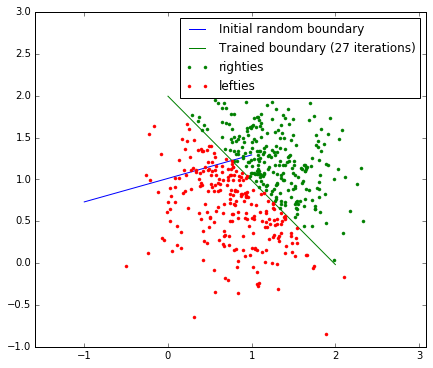

In [52]:
perceptron = np.random.uniform(-.1, .1, 3)

plot_decision_boundary(perceptron, label="Initial random boundary")

n_iterations = train_perceptron_until_no_misclassifications(perceptron, valued_training_data)

plot_perceptron_and_training_data(perceptron, "Trained boundary ({} iterations)".format(n_iterations))

Again, since we're relying on randomness to both initialize the perceptron weights and generate our training data, results of this step will vary. In most cases, this should take some time to run and we should see a large number of iterations. In general, though, we might not want to train our model _that_ much. Getting our model so fine-tuned to the training data could actually make it perform _worse_ when we use it to classify unlabeled, unseen data afterwards. This phenomenom is known as __overfitting__. We can think of it as "overdoing" the training so that our model becomes so specific to the training data that it gets worse "in the big picture". In our simple example, our data is well behaved enough that overfitting will most likely not be an issue. Either way, it's a good a idea for us to keep that in the back of your mind whenever we're training a model.

There are ways we can avoid overfitting. We could, for instance, use a training/validation process called cross-validation, in which we split the training data set further into training and validation sets. A simpler, less flexible alternative is just stopping the training phase arbitrarily a little earlier. Without worrying too much for now, let's just create a `train_perceptron_until_good_enough` function that runs until it classifies 98% of the training data correctly.

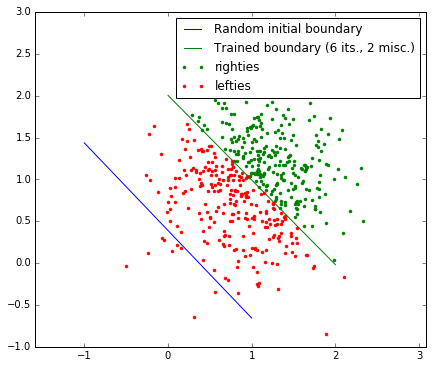

In [55]:
def train_perceptron_until_good_enough(perceptron, training_data, learning_rate=0.1, max_misclassified_pct=0.02):
    n_iterations = 0
    n_misclassified = len(training_data)
    
    while float(n_misclassified)/len(training_data) >= max_misclassified_pct:
        n_misclassified = train_perceptron(perceptron, training_data, learning_rate)
        n_iterations += 1
        
    return n_iterations, n_misclassified

perceptron = np.random.uniform(-.1, .1, 3)

plot_decision_boundary(perceptron, label="Random initial boundary")

n_iterations, n_misclassified = train_perceptron_until_good_enough(perceptron, valued_training_data)

plot_perceptron_and_training_data(perceptron,
                                  "Trained boundary ({} its., {} misc.)".format(n_iterations, n_misclassified))

Great! We were able to train our model "well enough" using only a few iterations.

To sum it up, we have so far talked about what a perceptron is, how it can be used for classification and how it can _taught_ how to classify from examples. Next, we're gonna talk a little bit about regression, which is another powerful machine learning technique.

# Freebie: Regression

We've seen how we can train a perceptron and how we can use it to _classify_ unlabelled, unseen data points. There's also another important machine learning task we can _already perform, almost for free_. This task is called (linear) regression and it provides answers to problems such as the following.

Suppose it's late 17th century and we're studying the behavior of springs. We're interested in finding the relationship between how much force we apply to a spring and how much it stretches or compresses. We set up an experiment like this:

![Spring-mass system](files/spring_mass.png)
_source: wikipedia_

We attach different masses (`m` values) and write down pairs of (spring_displacement, force_applied).

We got the following data points:

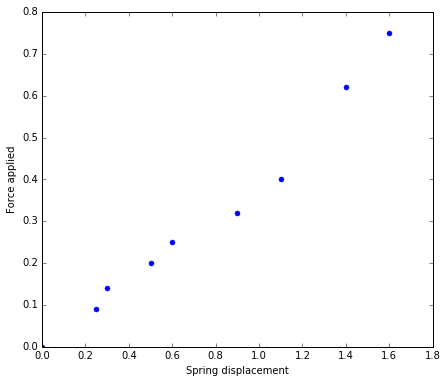

In [17]:
# Data points consists of pairs of (spring_displacement, force_applied)
spring_data_points = [
    (0., 0.),
    (.25, .09),
    (.3, .14),
    (.5, .2),
    (.9, .32),
    (.6, .25),
    (1.1, .4),
    (1.6, .75),
    (1.4, .62),
]

plot_tuples(spring_data_points, "b.", markersize=10)
plt.xlabel("Spring displacement")
plt.ylabel("Force applied")

You take a look at your notebook and think to yourself: it _seems_ like the displacent and force are linearly related. If that's really the case, we should expect the following equation to hold:

$$F(x) = kx + c$$

where $x$ is the spring displacement and $F$ is the applied force.

Since it's late 1600's and our measurement gear isn't that precise yet, there is some _noise_ in our measures. You can see from the plot that the points do not form a perfect line, but there's certainly a _tendency_.

The problem then is: If these data points really form a line, What is the value of $k$ and $c$ in that equation? Or, more nicely put, given a set of observations and our suggestion that they're linearly related, what's the underlying physical law that caused that relationship between the displacement and the applied force? The procedure to find an equation that models that behavior is called regression. In this case, since we're going to _force_ the relationship to be linear, so we can call it an instance of _linear regression_.

We saw how our perceptron has a way of learning a linear decision boundary from a set of examples. We can use the same idea to handle regression. The algorithm is the exact same, but our _interpretation_ of it might differ:

- Learning classification: given a set of observations with two classes of data points, find a linear decision boundary that separates the two classes well enough. In the training step, make small adjustments whenever we classify a point incorrectly.

- Learning regression: given a set of observations, find a linear equation that models how those points were "generated". In the training step, make small adjustments whenever a data point is "far" from the current line equation.


Let's feed these data points to our perceptron and see what it spits out. The only change I made to the training algorithm is that, instead of correcting for the difference between the perceptron's binary output and the training data output, I'm using the perceptron's _linear output_, since we're interested in capturing the linear behavior itself.

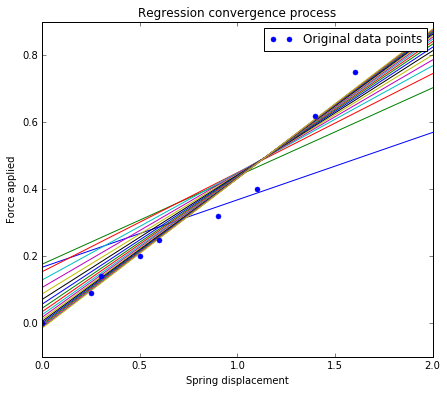

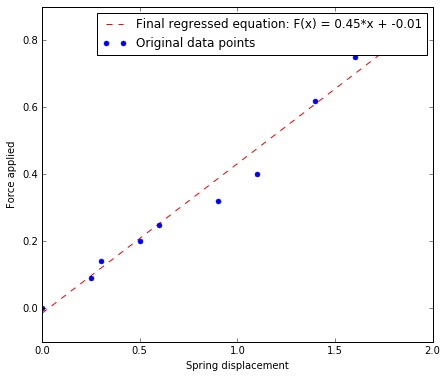

In [18]:
# In this case, our perceptron has just one input, the displacement. As in the function
# we're looking for, the output is the applied force
perceptron = np.random.uniform(-.1, .1, 2)

formatted_spring_data_points = [([input_], output) for input_, output in spring_data_points]

def train_linear_perceptron(perceptron, training_data, learning_rate=0.1):
    for training_inputs, training_output in training_data:   
        
        # Changed perceptron_output() to perceptron_linear_output()
        output = perceptron_linear_output(perceptron, training_inputs)
            
        training_inputs_with_bias = np.insert(training_inputs, 0, 1.)
        deltas = learning_rate*(training_output - output)*training_inputs_with_bias
        perceptron += deltas

        
x = np.array([0, 2])

for i in range(20):
    train_linear_perceptron(perceptron, formatted_spring_data_points)
    c, k = perceptron
    plt.plot(x, k*x + c)

plot_tuples(spring_data_points, "b.", label="Original data points", markersize=10)
plt.xlabel("Spring displacement")
plt.ylabel("Force applied")
plt.title("Regression convergence process")
plt.legend()
plt.show()

plt.plot(x, k*x + c, "r--", label="Final regressed equation: F(x) = {:.2f}*x + {:.2f}".format(k, c))
plot_tuples(spring_data_points, "b.", label="Original data points", markersize=10)
plt.xlabel("Spring displacement")
plt.ylabel("Force applied")
plt.legend()

If we're confident enough that the regressed line models the dataset well enough, I've got some big news... It's late 1600's and we just dicovered Hooke's law! In plain English, we just found out that the _displacement of a spring is proportinal to the force applied to it_.

Fantastic. Let's update the list of things we can do with our simple perceptron:

- Classification: points, given a linear decision boundary;
- Learning: teach linear decision boundaries from examples;
- Regression: find linear equations that model sets of observed data.

Note that everything we can do so far has the word "linear" in it. In real world applications, most datasets are not so well behaved. Next, we're gonna briefly discuss some more interesting datasets, which we cannot model so well with our simple, single neuron.

# Not linearly separable data

Yes, I agree. That was pretty awesome. We were able to actually _teach_ a freaking thingy how to classify points just by supplying it with some examples. Not only that, we could even use our simple learning algorithm to do regression on a set of observed data points!

In our examples so far, our examples have been almost intuitive:

- In classification, we could almost _see_ a line separating the "lefties" from "righties";
- In regression, we could almost free-handly draw a straight line that represent the observed data points well enough.

Now we're going to investigate a more interesting dataset. Let's try to come up with an example in which two classes of points are not linearly separable. We're going to spread a bunch of points around the origin and divide the data into two classes:

- Andies: points belonging to the first quadrant (both coordinates are positive)
- Nandies: points belonging to the second, third and forth quadrants

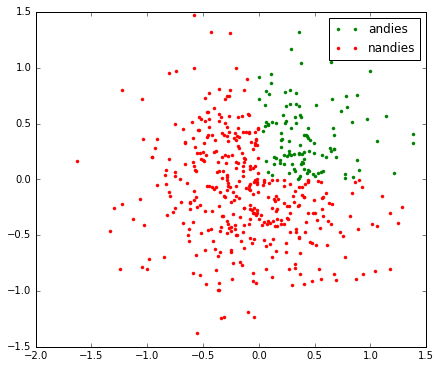

In [19]:
def attach_label(point):
    return (point, "andy" if point[0] > 0. and point[1] > 0. else "nandy")
    
labeled_points = [attach_label(np.random.normal(0, .5, 2)) for _ in xrange(500)]

# Let's also plot our training_data for intuition
andies = [td[0] for td in labeled_points if td[1] == "andy"]
nandies = [td[0] for td in labeled_points if td[1] == "nandy"]
    
plot_tuples(andies, "g.", label="andies")
plot_tuples(nandies, "r.", label="nandies")
plt.legend()

It's now not very clear how we'd go about drawing a line separating the green-andies and red-nandies points. This dataset is said not to be linearly separable.

Still, I'm a little curious to see what kind of linear boundary our learning algorithm would come up for it. Let's try it out.

Our routines `train_perceptron_until_no_mismatch` and `train_perceptron_until_good_enough` probably won't work very well. Both of them will cause the computation to never finish, since we won't ever be able to have less than 98% of correct classifications. Instead, I'm gonna simply run the training algorithm a few dozen times, arbitrarily.

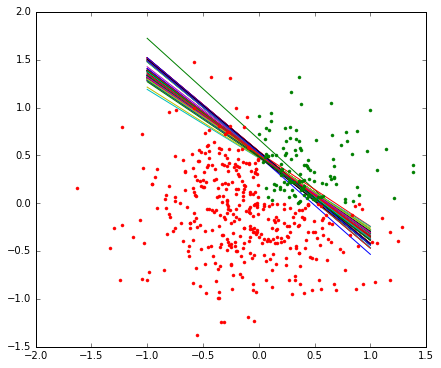

In [20]:
perceptron = np.random.uniform(-.1, .1, 3)

# Swap "andy" for 1. and "nandy" for 0. in our training data
valued_training_data = [(point, 1. if label == "andy" else 0.) for point, label in labeled_points]

plot_decision_boundary(perceptron, label="Random initial boundary")

n_missclassifieds = []

for _ in xrange(100):
    n_misclassified = train_perceptron(perceptron, valued_training_data)
    plot_decision_boundary(perceptron)
    n_missclassifieds.append(n_misclassified)
    
plot_tuples(andies, "g.")
plot_tuples(nandies, "r.")

Something weird is definitely going on. In each training iteration, the decision boundary seems to rotating and moving back and forth, without being able to figure out what's the best configuration to separate the data.

In fact, we can see that the number of misclassified points oscillate up and down with every pass over our training data:

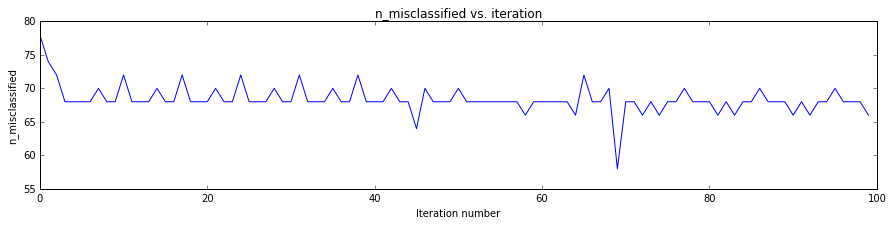

In [21]:
figsize(15, 3)
plt.plot(n_missclassifieds)
plt.title("n_misclassified vs. iteration")
plt.xlabel("Iteration number")
plt.ylabel("n_misclassified")
figsize(7, 6)

This kind of behavior is a symptom that we're tackling this problem with the wrong tools. We're trying to model our data - which is not linearly separable - with a linear decision boundary. In this case, we can say that our learning algorithm is not _converging_ to a good model, since it exhibits this nasty oscillatory behavior.

So now we have two pieces of equally valuable information:

- What our model _can_ do: model, learn and classify arbitrary, linearly separable datasets;
- What our model _cannot_ do: work with data that is not linearly separable.

In my opinion, that seems like a great tradeoff for such a simple model. Still, we're barely touching the surface of what artificial neural networks are capable. So far, we have been working with a single __neuron__, whereas a __neural network__, as the name implies, consists of several neurons.

In the next post, we're investigating how we can _connect_ several perceptrons to create an even more powerful model. We're hopefully going to be able to model and classify complex nonlinear datasets, with way more than two classes, and even use it to make complex decisions!

References
==========

[0] Machine Learning, Tom Mitchell, McGraw Hill, 1997.